In [2]:
import numpy as np
# import emcee
import scipy.io as scio
from scipy.linalg import inv, cholesky, solve_triangular
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline
rng = np.random.default_rng(127)    # For reproduction

file_mat = scio.loadmat('response_matrix.mat')
response_matrix = file_mat['response_int']
m, n = response_matrix.shape

## Generate example data

- Radial positions: $\vec{\rho} = [0.0, 0.01, 0.02, \ldots, 1.0]^{\top}$
- Density profile: $\vec{n}_e = [n_e(0.0), n_e(0.01), n_e(0.02), \ldots, n_e(1.0)]^{\top}$
- Line-integrated density: $\vec{d}_{\mathrm{int}} = R \cdot \vec{n}_e$ where $R_{m \times n}$ is called the response matrix

In [3]:
rho = np.linspace(0.0, 1.0, n)    # Radial positions
ne_true = -2 * rho**2 + 2    # Density profile
lid = np.dot(response_matrix, ne_true) + 0.05 * rng.normal(size=m)    # Synthetic line-integrated density
channel = np.arange(1, m+1)

Text(0.5, 1.0, '(Noisy) line-integrated density')

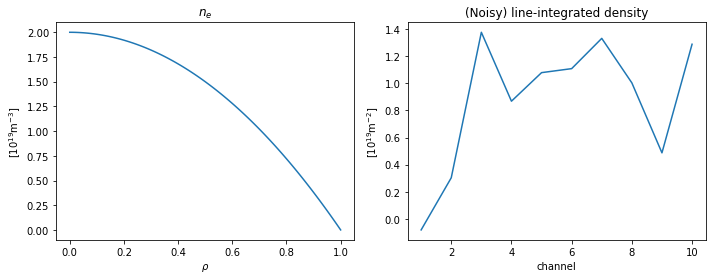

In [4]:
fig = plt.figure(figsize=(10, 4), layout='tight')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(rho, ne_true)
ax1.set_xlabel(r'$\rho$')
ax1.set_ylabel(r'[$10^{19}\mathrm{m^{-3}}$]')
ax1.set_title(r'$n_e$')

ax2.plot(channel, lid)
ax2.set_xlabel(r'channel')
ax2.set_ylabel(r'[$10^{19}\mathrm{m^{-2}}$]')
ax2.set_title(r'(Noisy) line-integrated density')

## Likelihood

Assuming the measured line-integrated density has a noise $\sigma_i \sim \mathcal{N}(0, 0.05^2)$ where $i$ is the channel number

- $p(\vec{d}_{\mathrm{int}} \mid \vec{n}_e) = \mathcal{N}(R \cdot \vec{n}_e, \Sigma_d)$ where $\Sigma_d = 0.05^2 \cdot I$

- Its logarithm
$$
\begin{aligned}
\log p(\vec{d}_{\mathrm{int}} | \vec{n}_e) &= -\frac{1}{2}\left[m\log(2\pi) + \log\vert\Sigma_d\vert + (\vec{d}_{\mathrm{int}}-R \cdot \vec{n}_e)^{\top} \Sigma_d^{-1} (\vec{d}_{\mathrm{int}}-R \cdot \vec{n}_e)\right] \\
&= -\frac{1}{2}\left[ m\log(2\pi) + 2 m \log(0.05) + \frac{1}{0.05^2} (\vec{d}_{\mathrm{int}}-R \cdot \vec{n}_e)^{\top} (\vec{d}_{\mathrm{int}}-R \cdot \vec{n}_e) \right]
\end{aligned}
$$

## Gaussian process prior

Assuming the prior distribution of the density profile is a (zero-mean) Gaussian process

- $p(\vec{n}_e) = \mathcal{GP}(\vec{0}, \Sigma)$ where the covariance matrix $\Sigma$ is determined by a kernel function $k(\rho_i, \rho_j)$

- We can use, for example, the simple squared-exponential kernel: $k(\rho_i, \rho_j) = \sigma_f^2 \exp\left[-\frac{(\rho_i-\rho_j)^2}{2\sigma_l^2}\right]$

In [5]:
def se_kernel(sigma_f, sigma_l):
    K = sigma_f**2 * np.exp(-0.5 * (rho[:, np.newaxis] - rho[np.newaxis, :])**2 / sigma_l**2)
    K[np.diag_indices_from(K)] += 1e-8    # Add a small value to diagonal terms to ensure the positive definiteness 
    return K

### Varying the length scale $\sigma_l$

We let $\sigma_f$ to be fixed at $1.0$ and vary the value of $\sigma_l$, and draw samples from the corresponding Gaussian process prior distribution. 

In [6]:
def plot_prior_samples(sigma_l, num_samples=5):
    K = se_kernel(1.0, sigma_l)
    try:
        L = cholesky(K, lower=True, check_finite=False)
    except np.linalg.LinAlgError as exc:
        exc.args = (
            "The kernel is not returning a positive "
            "definite matrix.",
        ) + exc.args
        raise
    # Draw samples from the multivariate normal distribution. See https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Drawing_values_from_the_distribution
    x = rng.normal(size=(n, num_samples))    
    samples = L @ x
    # Plot
    fig, ax = plt.subplots()
    for i in range(num_samples):
        ax.plot(rho, samples[:, i])
    ax.set_xlabel(r'$\rho$')
    ax.set_ylabel(r'[$10^{19}\mathrm{m^{-3}}$]')
    ax.set_title(fr'Sample profiles from GP prior ($\sigma_l = {sigma_l: .2f}$)')

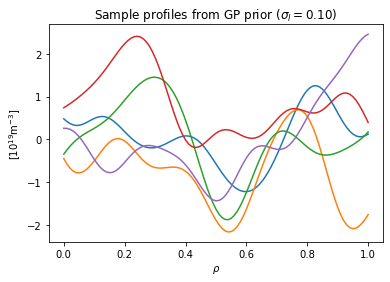

In [7]:
plot_prior_samples(sigma_l = 0.1)

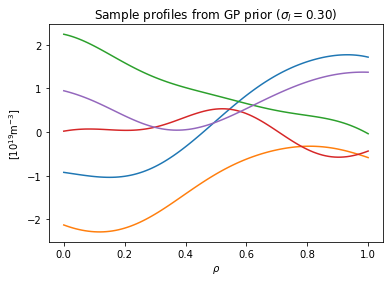

In [8]:
plot_prior_samples(sigma_l = 0.3)

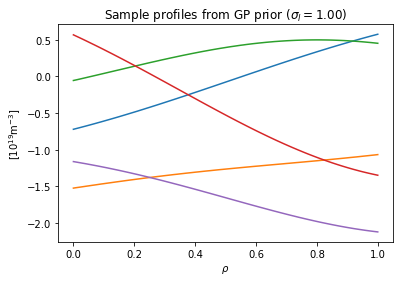

In [9]:
plot_prior_samples(sigma_l = 1.0)

### Hyperparameter optimization

We can optimize the hyperparameters $\vec{\theta}$ by maximizing the marginal likelihood $\mathrm{p}(\vec{d}_{\mathrm{int}}|\vec{\theta}) = \int \mathrm{p}(\vec{d}_{\mathrm{int}}|\vec{n}_e,\vec{\theta}) \mathrm{p}(\vec{n}_e|\vec{\theta}) \mathrm{d}\vec{n_e}$

In our case, both prior and likelihood are Gaussian, and the forward model is linear, therefore the marginal likelihood can be calculated analytically, and the log marginal likelihood is:

$$
\log\left[\mathrm{p}(\vec{d}_{\mathrm{int}}|\vec{\theta})\right] = -\frac{1}{2}[m \log(2\pi) + \log\vert \Sigma_d + R \Sigma R^{\top}\vert + \vec{d}_{\mathrm{int}}^{\top}(\Sigma_d + R \Sigma R^{\top})^{-1} \vec{d}_{\mathrm{int}}]
$$

In [10]:
# Maximizing the marginal likelihood is equivalent to minimizing its opposite
def get_loss(hypers):
    sigma_f = hypers[0]
    sigma_l = hypers[1]
    prior_cov = se_kernel(sigma_f, sigma_l)
    cov_d = 0.05**2 * np.eye(m)
    # Compute Σd + R(Σ)R'
    K = cov_d + np.linalg.multi_dot([response_matrix, prior_cov, response_matrix.T])
    try:
        L = cholesky(K, lower=True, check_finite=False)
    except np.linalg.LinAlgError:
        return np.inf
    # compute the loss
    v = solve_triangular(L, lid, lower=True, check_finite=False)
    loss = 2 * np.log(np.diag(L)).sum() + v.T @ v
    return loss

In [12]:
result = minimize(fun=get_loss, x0=[1.0, 0.2])
print(result)
hypers_opt = result.x
print("Optimized hyperparameters:")
print(f"sigma_f = {hypers_opt[0]:.2f}")
print(f"sigma_l = {hypers_opt[1]:.2f}")

      fun: -29.16169394125354
 hess_inv: array([[0.10603083, 0.04798155],
       [0.04798155, 0.05346269]])
      jac: array([3.19242477e-04, 5.62667847e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 215
      nit: 18
     njev: 68
   status: 2
  success: False
        x: array([1.55507015, 0.78114223])
Optimized hyperparameters:
sigma_f = 1.56
sigma_l = 0.78


## Posterior distribution

### Analytical solution

In our case, both prior and likelihood are Gaussian, and the forward model is linear, so the posterior distribution is also a multivariate Gaussian distribution and its mean and covariance can be solved analytically.

$$
\begin{aligned}
\Sigma^{\mathrm{post}} &= (R^{\top} \Sigma_d^{-1} R + \Sigma^{-1})^{-1}
\\
\vec{\mu}^{\mathrm{post}} &= (R^{\top} \Sigma_d^{-1} R + \Sigma^{-1})^{-1} R^T \Sigma_d^{-1} \vec{d}_{\mathrm{int}}
\end{aligned}
$$

In [11]:
def compute_posterior(sigma_f, sigma_l):
    prior_cov = se_kernel(sigma_f, sigma_l)
    cov_d = 0.05**2 * np.eye(m)
    post_cov = inv(response_matrix.T @ inv(cov_d) @ response_matrix + inv(prior_cov))
    u = lid / np.diag(cov_d)
    post_mean = np.dot(post_cov @ response_matrix.T, u)
    return post_mean, post_cov

In [12]:
post_mean, post_cov = compute_posterior(hypers_opt[0], hypers_opt[1])
post_std = np.sqrt(np.diag(post_cov))

Text(0.5, 1.0, 'Line integrated density')

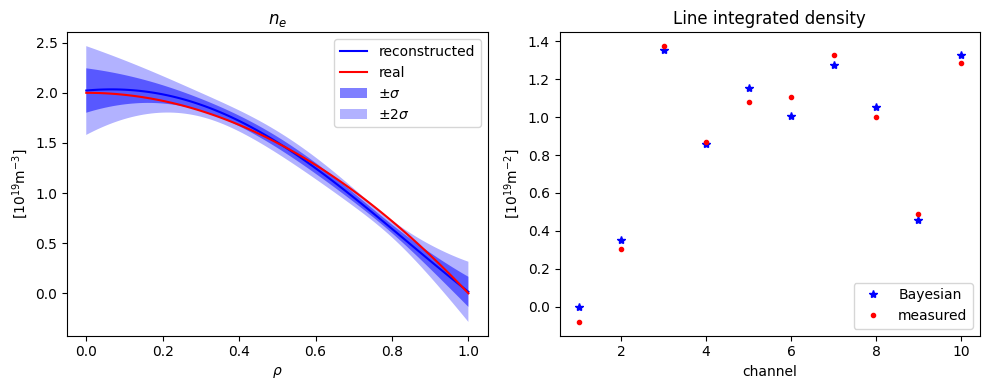

In [13]:
fig = plt.figure(figsize=(10, 4), layout='tight')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(rho, post_mean, color='blue', label='reconstructed')
ax1.plot(rho, ne_true, color='red', label='real')
ax1.fill_between(rho, post_mean - post_std, post_mean + post_std,
                 color='blue', edgecolors='none', alpha=0.5, label=r'$\pm \sigma$')
ax1.fill_between(rho, post_mean - 2 * post_std, post_mean + 2 * post_std,
                 color='blue', edgecolors='none', alpha=0.3, label=r'$\pm 2\sigma$')
ax1.legend()
ax1.set_xlabel(r'$\rho$')
ax1.set_ylabel(r'[$10^{19} \mathrm{m}^{-3}$]')
ax1.set_title('$n_e$')

lid_recon = np.dot(response_matrix, post_mean)
ax2.plot(channel, lid_recon, 'b*', label='Bayesian')
ax2.plot(channel, lid, 'r.', label='measured')
ax2.legend()
ax2.set_xlabel('channel')
ax2.set_ylabel(r'[$10^{19} \mathrm{m}^{-2}$]')
ax2.set_title('Line integrated density')

### MCMC sampling

$$
\begin{aligned}
\log p(\vec{d}_{\mathrm{int}} | \vec{n}_e) &= -\frac{1}{2}\left[m\log(2\pi) + \log\vert\Sigma_d\vert + (\vec{d}_{\mathrm{int}}-R \cdot \vec{n}_e)^{\top} \Sigma_d^{-1} (\vec{d}_{\mathrm{int}}-R \cdot \vec{n}_e)\right] \\
&= -\frac{1}{2}\left[ m\log(2\pi) + 2 m \log(0.05) + \frac{1}{0.05^2} (\vec{d}_{\mathrm{int}}-R \cdot \vec{n}_e)^{\top} (\vec{d}_{\mathrm{int}}-R \cdot \vec{n}_e) \right]
\end{aligned}
$$

In [14]:
prior_cov = se_kernel(hypers_opt[0], hypers_opt[1])

try:
    L_prior = cholesky(prior_cov, lower=True, check_finite=False)
except np.linalg.LinAlgError as exc:
    exc.args = (
        "The kernel is not returning a positive "
        "definite matrix.",
    ) + exc.args
    raise

# Use reparameterized prior distribution. 
# Take samples from a standard normal distribution and map them to the desired prior distribution using affine transformation
def log_posterior(x):
    log_prior = -0.5 * (n * np.log(2 * np.pi) + np.dot(x, x))
    ne = np.dot(L_prior, x)
    diff = lid - np.dot(response_matrix, ne)
    log_like = -0.5 * (m * np.log(2 * np.pi) + 2 * m * np.log(0.05)
                               + np.sum(diff**2 / 0.05**2))
    return log_prior + log_like

Find MAP estimate:

In [15]:
negative_logpdf = lambda x: -log_posterior(x)
x0 = np.zeros(n)
result = minimize(fun=negative_logpdf, x0=x0)
x_map = result.x
ne_map = np.dot(L_prior, x_map)

Text(0.5, 1.0, 'MAP estimate of $n_e$')

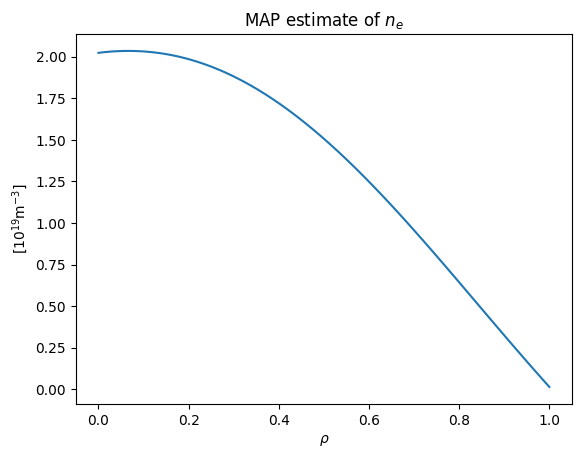

In [16]:
fig, ax = plt.subplots()
ax.plot(rho, ne_map)
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'[$10^{19} \mathrm{m}^{-3}$]')
ax.set_title('MAP estimate of $n_e$')

Sampling:

In [17]:
nwalkers = n * 2
x_start = x_map + 0.01 * np.random.randn(nwalkers, n)
num_samples = 1000
burnin = 2000

sampler = emcee.EnsembleSampler(nwalkers, n, log_posterior)
sampler.run_mcmc(x_start, burnin + num_samples, progress=True)
x_samples = sampler.get_chain(discard=burnin, flat=True)
ne_samples = x_samples @ L_prior.T
ne_mean = ne_samples.mean(axis=0)
ne_lower = np.percentile(ne_samples, 2.5, axis=0)
ne_upper = np.percentile(ne_samples, 97.5, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:15<00:00, 39.87it/s]


Visualization:

Text(0.5, 1.0, 'Line integrated density')

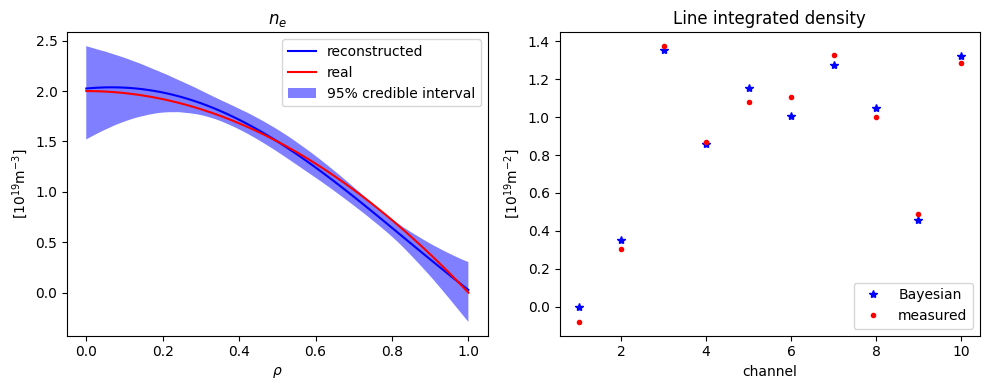

In [18]:
fig = plt.figure(figsize=(10, 4), layout='tight')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(rho, ne_mean, color='blue', label='reconstructed')
ax1.plot(rho, ne_true, color='red', label='real')
ax1.fill_between(rho, ne_lower, ne_upper,
                 color='blue', edgecolors='none', alpha=0.5, label='95% credible interval')
ax1.legend()
ax1.set_xlabel(r'$\rho$')
ax1.set_ylabel(r'[$10^{19} \mathrm{m}^{-3}$]')
ax1.set_title('$n_e$')

lid_recon = np.dot(response_matrix, ne_mean)
ax2.plot(channel, lid_recon, 'b*', label='Bayesian')
ax2.plot(channel, lid, 'r.', label='measured')
ax2.legend()
ax2.set_xlabel('channel')
ax2.set_ylabel(r'[$10^{19} \mathrm{m}^{-2}$]')
ax2.set_title('Line integrated density')